In [51]:
# What version of Python do you have?
import sys
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colorama import Fore, Back, Style
import numpy as np
from keras.optimizers import Adam
from gc import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from preprocess import resize_images,cropBorders, remove_areas,resize_full_image,show_grid_of_images,make_dataset
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")



Python Platform: macOS-12.6-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.5.0
Scikit-Learn 1.1.2
GPU is available


In [52]:
dicom_data = pd.read_csv('archive/csv/dicom_info.csv')
metadata = pd.read_csv('archive/csv/meta.csv')
df_mass_train = pd.read_csv('archive/csv/mass_case_description_train_set.csv')
df_mass_test = pd.read_csv('archive/csv/mass_case_description_test_set.csv')
dicom_data

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.62798...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.627982...,NaN,8,8,BREAST,3744,20160503,134238.422,WSD,...,MATLAB,ROI mask images,1.3.6.1.4.1.9590.100.1.2.627982547125586065005...,1,0,ISO_IR 100,20170906.0,DDSM,1.3.6.1.4.1.9590.100.1.2.310901637111684385906...,91038.0
10233,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.82451...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.824512...,NaN,16,16,BREAST,3316,20160426,123905.617,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.824512568105677732346...,1,0,ISO_IR 100,20161004.0,DDSM,1.3.6.1.4.1.9590.100.1.2.246896536912401556922...,132704.0
10234,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24759...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247594...,NaN,16,16,BREAST,2712,20160426,134551.632,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.247594800112988856209...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.150339554012064216510...,191922.0
10235,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.28513...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138...,NaN,8,8,BREAST,2736,20160426,110906.969,WSD,...,MATLAB,ROI mask images,1.3.6.1.4.1.9590.100.1.2.285138900913160236325...,1,0,ISO_IR 100,20160721.0,DDSM,1.3.6.1.4.1.9590.100.1.2.426769868613284096628...,83526.0


In [53]:
image_dir = 'archive/jpeg'

In [54]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images']
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images']
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images']

In [6]:
#for info in zip(cropped_images.iloc[0].index, cropped_images.iloc[0]):
#    print(f'{Fore.GREEN}{info[0]}{Style.RESET_ALL}:',info[1])

In [55]:
mass_cropped_train = cropped_images[cropped_images.PatientID.isin(df_mass_train['cropped image file path'].apply(lambda x: x.split('/')[0]))]
mass_cropped_test = cropped_images[cropped_images.PatientID.isin(df_mass_test['cropped image file path'].apply(lambda x: x.split('/')[0]))]
mass_ROI_train = ROI_mask_images[ROI_mask_images.PatientID.isin(df_mass_train['ROI mask file path'].apply(lambda x: x.split('/')[0]))]
mass_ROI_test = ROI_mask_images[ROI_mask_images.PatientID.isin(df_mass_test['ROI mask file path'].apply(lambda x: x.split('/')[0]))]
mass_full_train = full_mammogram_images[full_mammogram_images.PatientID.isin(df_mass_train['image file path'].apply(lambda x: x.split('/')[0]))]
mass_full_test = full_mammogram_images[full_mammogram_images.PatientID.isin(df_mass_test['image file path'].apply(lambda x: x.split('/')[0]))]
print(f"shape of mass_cropped_training: {mass_cropped_train.shape}")
print(f"shape of mass_cropped_test: {mass_cropped_test.shape}")
print(f"shape of mass_ROI_training: {mass_ROI_train.shape}")
print(f"shape of mass_ROI_test: {mass_ROI_test.shape}")
print(f"shape of mass_full_train: {mass_full_train.shape}")
print(f"shape of mass_full_test: {mass_full_test.shape}")

shape of mass_cropped_training: (1318, 38)
shape of mass_cropped_test: (378, 38)
shape of mass_ROI_training: (1318, 38)
shape of mass_ROI_test: (378, 38)
shape of mass_full_train: (1231, 38)
shape of mass_full_test: (361, 38)


In [8]:
#for info in zip(mass_ROI_train.iloc[0].index, mass_ROI_train.iloc[8]):
#    print(f'{Fore.GREEN}{info[0]}{Style.RESET_ALL}:',info[1])

In [56]:
cropped_train_images_path = mass_cropped_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_test_images_path = mass_cropped_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_train_images_path = mass_ROI_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_test_images_path = mass_ROI_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_training_images_path = mass_full_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_test_images_path = mass_full_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [57]:
#resize every image to same dimensions
resize_images(ROI_test_images_path,(256,256))
resize_images(ROI_train_images_path)

In [82]:
resize_full_image(full_test_images_path)
resize_full_image(full_training_images_path)

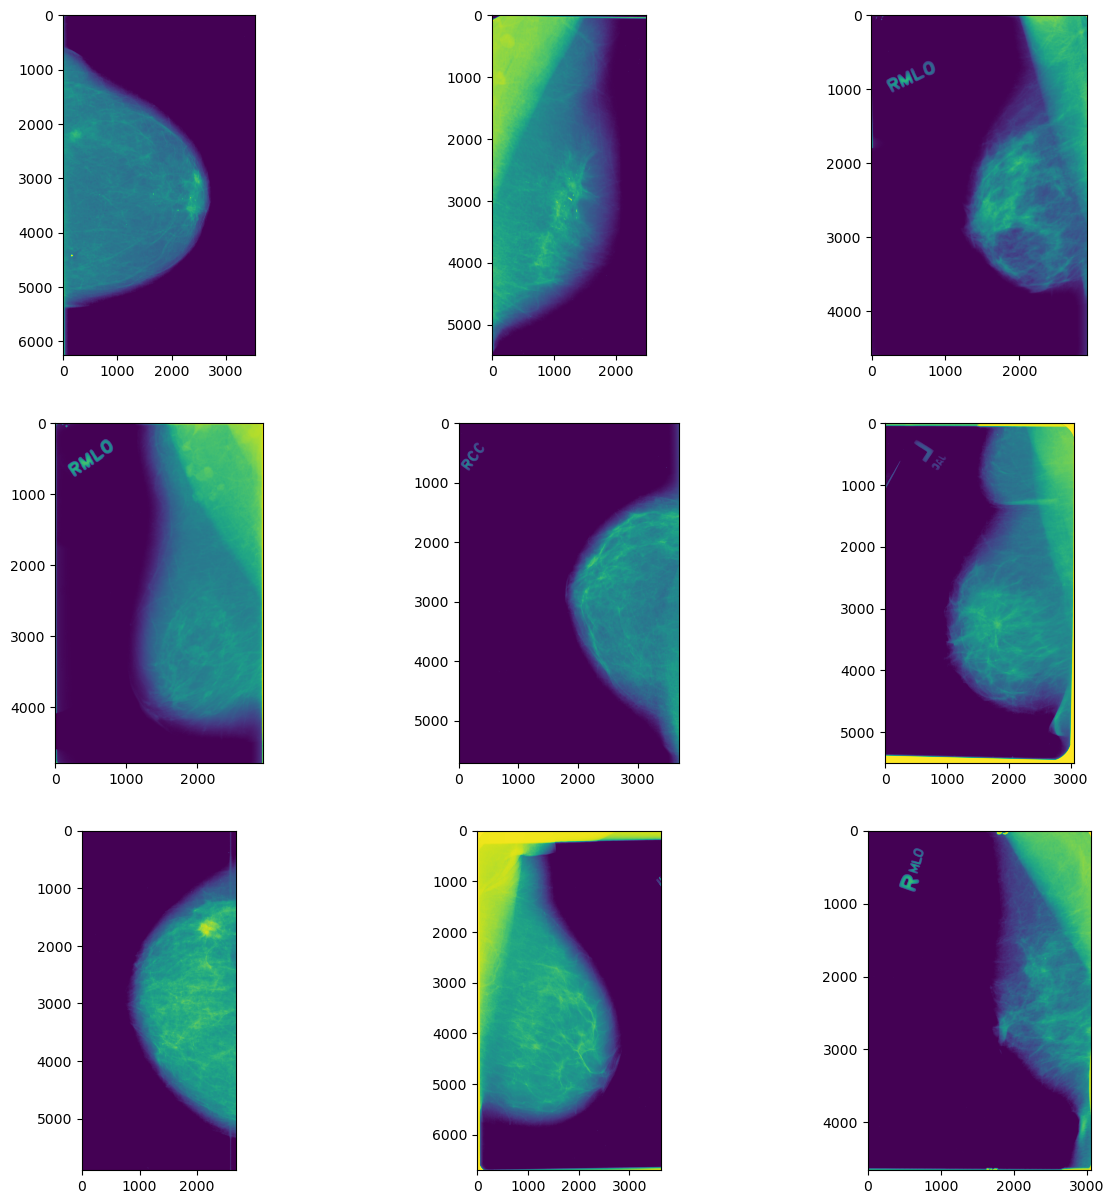

In [86]:
show_grid_of_images(full_training_images_path)

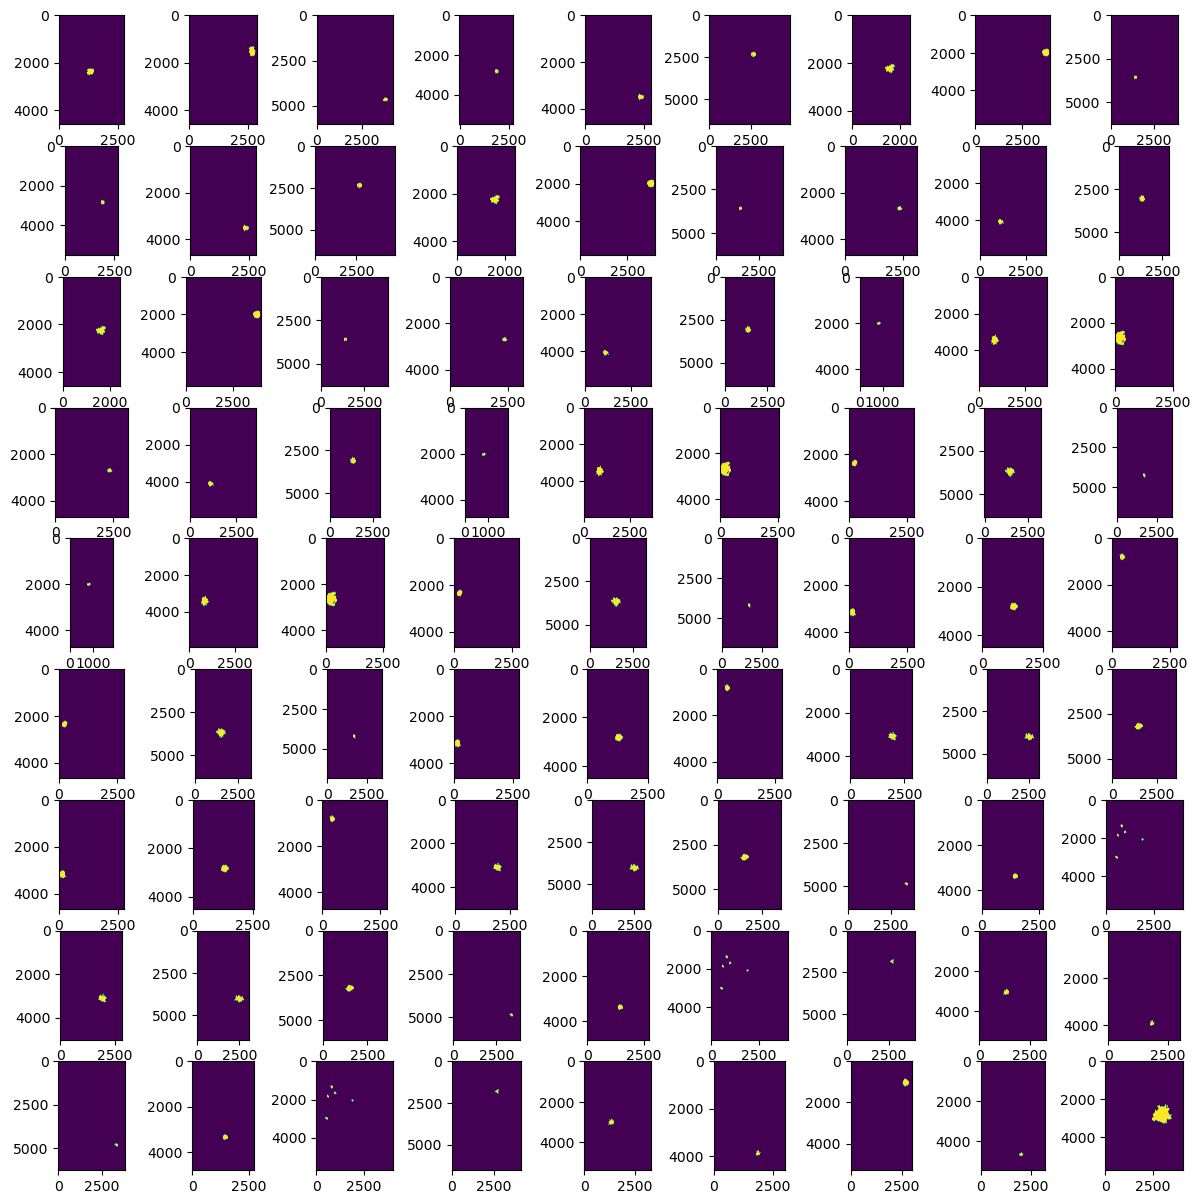

In [79]:
show_grid_of_images(ROI_train_images_path)

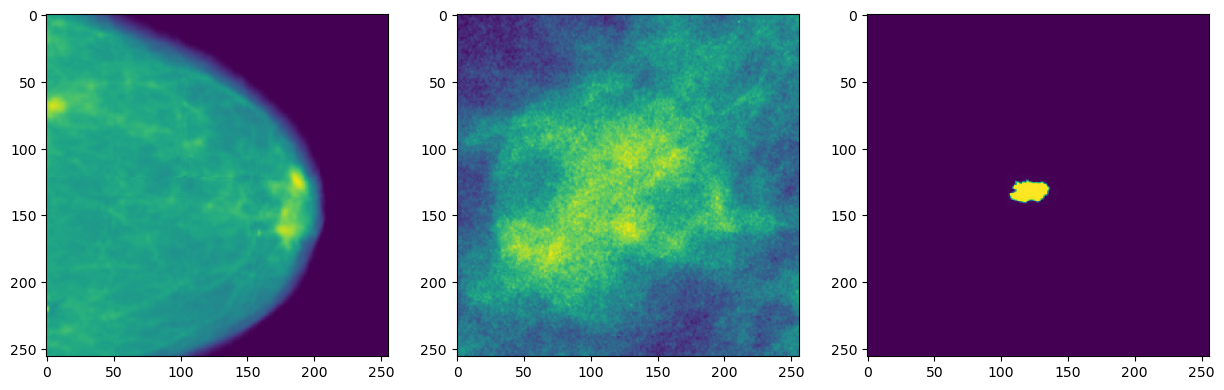

(256, 256)

In [15]:
img_ROI = cv.imread(ROI_train_images_path.values[0], cv.IMREAD_GRAYSCALE)
img_Cropped = cv.imread(cropped_train_images_path.values[0], cv.IMREAD_GRAYSCALE)
img_Full = cv.imread(full_training_images_path.values[0], cv.IMREAD_GRAYSCALE)
def show_images(img1, img2, img3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(img3)
    plt.show()
show_images(img_Full, img_Cropped, img_ROI)
img_Cropped.shape

In [61]:
#sum all roi images into one image, delete rest of roi images and duplicated cropped images for train
for i in range(2, 10):
    sub_df = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x: x.endswith(str(i)))]
    for _,row in sub_df.iterrows():
        #path to image we want to concatenate with _1
        row_img_path = row['image_path'].replace('CBIS-DDSM/jpeg', image_dir)
        img1 = cv.imread(row_img_path, cv.IMREAD_GRAYSCALE)
        #patient_id we want to delete later
        patient_id = row['PatientID']
        #patient id of top image
        patient_id_top =  row['PatientID'][0:-2] + '_1'
        img_path_2 = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
        if len(img_path_2.values) == 0:
            if i == 2: 
                continue
            else:
                patient_id_top =  row['PatientID'][0:-2] + '_2'
                img_path_2 = mass_ROI_train[mass_ROI_train['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
                if len(img_path_2.values) == 0:
                    continue
        img_path_2 = img_path_2.values[0]
        img2 = cv.imread(img_path_2, cv.IMREAD_GRAYSCALE)
        img3 = np.add(img1, img2)
        cv.imwrite(img_path_2, img3)
        mass_ROI_train = mass_ROI_train[mass_ROI_train.PatientID != row['PatientID']]

In [17]:
#concatenate all roi images into one image, delete rest of roi images and duplicated cropped images for test
for i in range(2, 10):
    sub_df = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x: x.endswith(str(i)))]
    for _,row in sub_df.iterrows():
        #path to image we want to concatenate with _1
        row_img_path = row['image_path'].replace('CBIS-DDSM/jpeg', image_dir)
        img1 = cv.imread(row_img_path, cv.IMREAD_GRAYSCALE)
        #patient_id we want to delete later
        patient_id = row['PatientID']
        #patient id of top image
        patient_id_top =  row['PatientID'][0:-2] + '_1'
        img_path_2 = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
        if len(img_path_2.values) == 0:
            if i == 2: 
                continue
            else:
                patient_id_top =  row['PatientID'][0:-2] + '_2'
                img_path_2 = mass_ROI_test[mass_ROI_test['PatientID'].apply(lambda x : x == patient_id_top)].image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
                if len(img_path_2.values) == 0:
                    continue
        img_path_2 = img_path_2.values[0]
        img2 = cv.imread(img_path_2, cv.IMREAD_GRAYSCALE)
        img3 = np.add(img1, img2)
        cv.imwrite(img_path_2, img3)
        mass_ROI_test = mass_ROI_test[mass_ROI_test.PatientID != row['PatientID']]
        #mass_cropped_test = mass_cropped_test[mass_cropped_test.PatientID != row['PatientID']]

In [18]:
mass_ROI_train.PatientID = mass_ROI_train.PatientID.apply(lambda x: x[0:-2])
mass_ROI_test.PatientID = mass_ROI_test.PatientID.apply(lambda x: x[0:-2])

In [19]:
mass_full_train = mass_full_train.sort_values(by=['PatientID'])
mass_full_test = mass_full_test.sort_values(by=['PatientID'])
mass_ROI_train = mass_ROI_train.sort_values(by=['PatientID'])
mass_ROI_test = mass_ROI_test.sort_values(by=['PatientID'])

In [75]:
cropped_train_images_path = mass_cropped_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_test_images_path = mass_cropped_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_train_images_path = mass_ROI_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_test_images_path = mass_ROI_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_train_images_path = mass_full_train.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir)).values
full_test_images_path = mass_full_test.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [21]:
train_X = make_dataset(full_train_images_path)
train_Y = make_dataset(ROI_train_images_path)
test_X = make_dataset(full_test_images_path)
test_Y = make_dataset(ROI_test_images_path)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-14 02:12:14.343067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-14 02:12:14.343207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
train_X = tf.convert_to_tensor(train_X)
train_Y = tf.convert_to_tensor(train_Y)
test_X = tf.convert_to_tensor(test_X)
test_Y = tf.convert_to_tensor(test_Y)

In [23]:
BATCH_SIZE = 64
NUM_EPOCHS = 32

In [24]:
def intersection_over_union(y_true, y_pred):
    
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    
    return x

In [25]:
def convolutional_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [26]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = convolutional_block(x, num_filters)
    return x

In [27]:
#input shape is (height,   width,   channels)
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)

In [28]:
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256, 256, 3)))

In [29]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)
 
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
 
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 256)                    
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                      
 
    """ Output """
    outputs = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
 
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
 
if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_vgg16_unet(input_shape)
    model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [30]:
steps_per_epoch = len(train_X) // BATCH_SIZE
validation_steps = len(test_X) // BATCH_SIZE
train = (train_X, train_Y)
validation_data = (test_X, test_Y)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
checkpoint = ModelCheckpoint("vgg16_1.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1,
                             save_freq = steps_per_epoch * 20)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(
    x = train_X,
    y = train_Y,
    validation_data = validation_data,
    epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks = [checkpoint, early]
)

Epoch 1/32


2022-10-14 02:12:15.811720: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-14 02:12:16.519907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 5.1250 - accuracy: 0.1917

2022-10-14 02:17:55.566957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 368s 4s/step - loss: 5.1250 - accuracy: 0.1917 - val_loss: 32.4827 - val_accuracy: 0.4126
Epoch 2/32
102/102 [==============================] - 369s 4s/step - loss: 4.9334 - accuracy: 0.0666
Epoch 3/32
102/102 [==============================] - 350s 3s/step - loss: 4.9412 - accuracy: 0.0542
Epoch 4/32
102/102 [==============================] - 369s 4s/step - loss: 5.0319 - accuracy: 0.1114
Epoch 5/32
102/102 [==============================] - 428s 4s/step - loss: 5.0727 - accuracy: 0.0815
Epoch 6/32
102/102 [==============================] - 413s 4s/step - loss: 4.9705 - accuracy: 0.1548
Epoch 7/32
102/102 [==============================] - 419s 4s/step - loss: 5.1417 - accuracy: 0.1206
Epoch 8/32
102/102 [==============================] - 436s 4s/step - loss: 5.3934 - accuracy: 0.0913
Epoch 9/32
102/102 [==============================] - 429s 4s/step - loss: 5.1864 - accuracy: 0.1371
Epoch 10/32
102/102 [==============================] - 415s

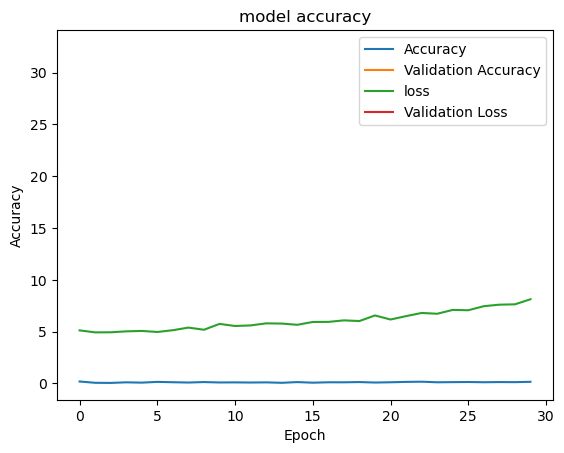

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [34]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]
def show_predictions(dataset=None, num=1):
   for i in range(test_X):
        image = test_X[i]
        mask = test_Y[i]
        pred_mask = history.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
        